In [1]:
 
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
import py3Dmol
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from skimage.transform import resize
from rdkit import Chem
from rdkit.Chem import AllChem
from Bio.PDB import PDBParser, PDBIO, Select
from PIL import Image
import biotite.structure.io.pdb as pdb
from collections import defaultdict
import glob
import random
from Bio.PDB import PDBParser, Vector
from Bio.PDB.vectors import rotaxis
from math import pi
from biotite.structure import AtomArray, find_aromatic_rings
from biotite.structure import BondList
import networkx as nx
import requests
import os
import time
#clear output on command
from IPython.display import clear_output
import json
from tqdm import tqdm
from Bio.PDB import   PPBuilder,Chain, Model
from Bio.SeqUtils import seq1
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import biotite.structure as struc
pdb_path=r'D:\PythonProj\Auto-EC\pdb_files\1FT5.pdb'

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import UNet2DModel, DDPMScheduler
from PIL import Image
import glob
import os
import re
import random
from tqdm import tqdm
import math
import torch.nn as nn
import torch.optim as optim

# Define common ions, solvents, and crystallization aids to remove
# This list might need refinement based on specific needs and whether metal ions are structural/functional
UNWANTED_HETATMS = {
    # Solvents"HOH","CA","SO4","IOD","NA","CL","GOL","PO4"
    "HOH", "WAT", "H2O", "DOD",
    # Common Ions (Consider if specific ions like ZN, MG, CA are part of the active site)
    "NA", "K", "CA", "MG", "ZN", "CU", "FE", "MN", "CO", "NI", "NA+", "K+", "CA+", "MG+", "ZN+", "CL-", "BR-",
    "CL", "BR", "IOD", "F",
    "SO4", "PO4", "NO3", "CO3", "ACY", "ACT", "EDO", "NH4",
    # Crystallization Aids / Buffers
    "GOL", "PEG", "PGE", "PG4", "P6G", "OLC", "BME", "MPD", "MES", "CAC",
    "CIT", "TAR", "TLA", "TRS", "EDTA", "IMD", "HEPES", "POU", "IPA", "PGA",
    # Add more as needed based on common contaminants or non-ligand molecules
}
# Van der Waals radii for common elements (in Angstroms)
vdwRadii = {
    'H': 1.2,
    'C': 1.7,
    'N': 1.55,
    'O': 1.52,
    'S': 1.8,
    'P': 1.8,
    'F': 1.47,
    'Cl': 1.75,
    'Br': 1.85,
    'I': 1.98,
    'Fe': 2.0,
    'Zn': 1.39,
    'Cu': 1.4,
    'Ni': 1.63
}


def load_pdb_and_extract_conect(pdb_file):
    """
    Load a PDB file and extract CONECT records
    
    Parameters:
    -----------
    pdb_file : str
        Path to the PDB file
        
    Returns:
    --------
    tuple
        (structure, conect_dict) where structure is a biotite structure object
        and conect_dict is a dictionary mapping atom serial numbers to their connected atoms
    """
    # Load the PDB file
    with open(pdb_file, 'r') as f:
        pdb_content = f.readlines()
    
    # Extract CONECT records
    conect_dict = defaultdict(list)
    for line in pdb_content:
        if line.startswith("CONECT"):
            # CONECT records format: "CONECT" followed by atom serial numbers
            # First number is the central atom, the rest are connected atoms
            fields = line.split()
            if len(fields) > 1:
                central_atom = int(fields[1])
                for i in range(2, len(fields)):
                    connected_atom = int(fields[i])
                    conect_dict[central_atom].append(connected_atom)
                    # Add reverse connection for undirected graph
                    conect_dict[connected_atom].append(central_atom)
    
    # Load structure using biotite
    structure = pdb.PDBFile.read(pdb_file)
    
    return structure, conect_dict

def get_ligand_atoms(structure, ligand_residue_id):
    """
    Extract atoms belonging to a specific ligand
    
    Parameters:
    -----------
    structure : biotite.structure.AtomArray
        Structure from PDB file
    ligand_residue_id : str
        Three-letter code of the ligand (e.g., 'HEM' for heme)
        
    Returns:
    --------
    dict
        Dictionary mapping atom indices to serial numbers
    """
    atom_indices = {}
    
    for i, residue in enumerate(structure.res_name):
        if residue == ligand_residue_id:
            atom_indices[structure.atom_id[i]] = i
    
    return atom_indices

def build_ligand_graph(structure, conect_dict, ligand_atoms):
    """
    Build a graph representation of the ligand using CONECT records
    
    Parameters:
    -----------
    structure : biotite.structure.AtomArray
        Structure from PDB file
    conect_dict : dict
        Dictionary mapping atom serial numbers to connected atoms
    ligand_atoms : dict
        Dictionary mapping atom serial numbers to atom indices
        
    Returns:
    --------
    networkx.Graph
        Graph representation of the ligand
    """
    G = nx.Graph()
    
    # Add nodes
    for atom_id in ligand_atoms:
        atom_idx = ligand_atoms[atom_id]
        atom_name = structure.atom_name[atom_idx]
        element = structure.element[atom_idx] if hasattr(structure, 'element') else atom_name[0]
        G.add_node(atom_id, name=atom_name, element=element)
    
    # Add edges from CONECT records
    for atom_id in ligand_atoms:
        if atom_id in conect_dict:
            for connected_atom in conect_dict[atom_id]:
                if connected_atom in ligand_atoms:
                    G.add_edge(atom_id, connected_atom)
    
    return G

def find_aromatic_ringsNX(G, min_ring_size=5, max_ring_size=7):
    """
    Find potential aromatic rings in the molecular graph
    
    Parameters:
    -----------
    G : networkx.Graph
        Molecular graph
    min_ring_size : int
        Minimum size of aromatic rings to consider
    max_ring_size : int
        Maximum size of aromatic rings to consider
        
    Returns:
    --------
    list
        List of lists containing atom IDs that form potential aromatic rings
    """
    # Find all cycles in the graph
    cycles = nx.cycle_basis(G)
    
    # Filter cycles by size
    potential_aromatic_rings = [cycle for cycle in cycles 
                               if min_ring_size <= len(cycle) <= max_ring_size]
    
    # Further filtering based on aromaticity criteria
    aromatic_rings = []
    for ring in potential_aromatic_rings:
        # Check if ring contains correct elements for aromaticity
        # For simplicity, we'll consider rings with C and N as potentially aromatic
        elements = [G.nodes[atom_id]['element'] for atom_id in ring]
        
        # Check if elements are mostly C, N, O, S (common in aromatic systems)
        aromatic_elements = [e for e in elements if e in ['C', 'N', 'O', 'S']]
        
        # If at least 75% of atoms are potential participants in aromaticity
        if len(aromatic_elements) / len(ring) >= 0.75:
            aromatic_rings.append(ring)
    
    return aromatic_rings

def is_heme(G, ring):
    """
    Check if a ring is part of a heme structure
    
    Parameters:
    -----------
    G : networkx.Graph
        Molecular graph
    ring : list
        List of atom IDs forming a ring
        
    Returns:
    --------
    bool
        True if the ring is likely part of a heme structure
    """
    # Heme typically has:
    # - Four pyrrole rings (five-membered rings with 4 C and 1 N)
    # - Iron (Fe) coordinated at the center
    
    # Check if the ring is a pyrrole (5-membered with 1 N and 4 C)
    if len(ring) != 5:
        return False
    
    elements = [G.nodes[atom_id]['element'] for atom_id in ring]
    if elements.count('N') != 1 or elements.count('C') != 4:
        return False
    
    # Check for iron nearby
    iron_nearby = False
    ring_neighbors = set()
    for atom_id in ring:
        ring_neighbors.update(G.neighbors(atom_id))
    
    ring_neighbors -= set(ring)  # Remove ring atoms
    
    for neighbor in ring_neighbors:
        if G.nodes[neighbor]['element'] == 'FE':
            iron_nearby = True
            break
    
    return iron_nearby

def analyze_pdb_for_aromatics(pdb_file, ligand_id):
    """
    Main function to analyze a PDB file for aromatic rings in a ligand
    
    Parameters:
    -----------
    pdb_file : str
        Path to the PDB file
    ligand_id : str
        Three-letter code of the ligand
        
    Returns:
    --------
    tuple
        (structure, aromatic_rings, heme_rings)
    """
    # Load PDB and extract CONECT records
    structure, conect_dict = load_pdb_and_extract_conect(pdb_file)
    
    # Get ligand atoms
    ligand_atoms = get_ligand_atoms(structure, ligand_id)
    
    # Build graph representation
    G = build_ligand_graph(structure, conect_dict, ligand_atoms)
    
    # Find aromatic rings
    aromatic_rings = find_aromatic_rings(G)
    
    # Identify heme rings
    heme_rings = [ring for ring in aromatic_rings if is_heme(G, ring)]
    
    # Remove heme rings from general aromatic rings
    aromatic_rings = [ring for ring in aromatic_rings if ring not in heme_rings]
    
    return structure, G, aromatic_rings, heme_rings

def CreateStack(model, ligand_info,boxSize_nm =2, gridSize =128 ):
    # Collect all backbone atoms
    backbone_atoms = []
    minX,minY,minZ = np.inf,np.inf,np.inf
    maxX,maxY,maxZ = -np.inf,-np.inf,-np.inf
    for chain in model:
        for residue in chain:
            if not residue.id[0] == " ":  # Skip heteroatoms
                continue
            resProps = residue_properties(residue)
            for atom in residue:
                if atom.id in ["N", "CA", "C", "O"]:  # Backbone atoms
                    atom.properties = resProps
                    backbone_atoms.append(atom)
                    # atom.coord = np.array(atom.coord)
                    # # Update min/max coordinates for bounding box
                    # minX = min(minX, atom.coord[0] - vdwRadii.get(atom.element, 1.2))
                    # minY = min(minY, atom.coord[1] - vdwRadii.get(atom.element, 1.2))
                    # minZ = min(minZ, atom.coord[2] - vdwRadii.get(atom.element, 1.2))
                    # maxX = max(maxX, atom.coord[0] + vdwRadii.get(atom.element, 1.2))
                    # maxY = max(maxY, atom.coord[1] + vdwRadii.get(atom.element, 1.2))
                    # maxZ = max(maxZ, atom.coord[2] + vdwRadii.get(atom.element, 1.2))
    
    boxSize_Ang=boxSize_nm*10
    maxX = ligand_info['center'][0] + boxSize_Ang/2
    maxY = ligand_info['center'][1] + boxSize_Ang/2
    maxZ = ligand_info['center'][2] + boxSize_Ang/2
    minX = ligand_info['center'][0] - boxSize_Ang/2
    minY = ligand_info['center'][1] - boxSize_Ang/2
    minZ = ligand_info['center'][2] - boxSize_Ang/2
                        
    grid3D_red = np.zeros((gridSize, gridSize, gridSize), dtype=np.float32)   
    grid3D_green = np.zeros((gridSize, gridSize, gridSize), dtype=np.float32)
    grid3D_blue = np.zeros((gridSize, gridSize, gridSize), dtype=np.float32)
    mask = np.zeros((gridSize, gridSize, gridSize), dtype=np.float32)
    
    voxelSizeX = (maxX - minX) / gridSize      
    voxelSizeY = (maxY - minY) / gridSize
    voxelSizeZ = (maxZ - minZ) / gridSize

    voxelSize = max(voxelSizeX, voxelSizeY, voxelSizeZ)

    for atomIndex  in range(len( backbone_atoms)):
        atom = backbone_atoms[atomIndex]
        x, y, z = atom.coord - np.array([minX, minY, minZ])
        
        if x < 0 or y < 0 or z < 0:
            continue
        if x>boxSize_Ang or y>boxSize_Ang or z>boxSize_Ang:
            continue
        x = int(x / voxelSize)
        y = int(y / voxelSize)
        z = int(z / voxelSize)
       
        radius = int( vdwRadii.get(atom.element, 1.2)/voxelSize)
        rsquared = radius * radius
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                for dz in range(-radius, radius + 1):
                    if dx**2 + dy**2 + dz**2 <= rsquared:
                        xx=x + dx
                        yy=y + dy
                        zz=z + dz
                        if 0 <= xx < gridSize and 0 <= yy < gridSize and 0 <= zz < gridSize:
                            grid3D_red[xx, yy,zz] = x/ gridSize   
                            grid3D_green[xx, yy,zz] = atom.properties["polarity"]
                            grid3D_blue[xx, yy,zz] = atom.properties["size"]
                            pass
                            
    print('ligand drawing')
    for atom_prop in ligand_info['atom_properties']:
        #element, charge, polarity = atom_prop['element'], atom_prop['charge'], atom_prop['polarity']
        x, y, z = np.array(atom_prop['coords']) - np.array([minX, minY, minZ])
        
        if x < 0 or y < 0 or z < 0:
            continue
        if x > boxSize_Ang or y > boxSize_Ang or z > boxSize_Ang:
            continue
        x = int(x  / voxelSize)
        y = int(y  / voxelSize)
        z = int(z  / voxelSize)
       
        radius = int(vdwRadii.get(atom_prop['element'], 1.2) / voxelSize)
        rsquared = radius * radius
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                for dz in range(-radius, radius + 1):
                    if dx**2 + dy**2 + dz**2 <= rsquared:
                        xx = x + dx
                        yy = y + dy
                        zz = z + dz
                        if 0 <= xx < gridSize and 0 <= yy < gridSize and 0 <= zz < gridSize:
                            grid3D_red[xx, yy, zz] = x/ gridSize   
                            grid3D_green[xx, yy, zz] = atom_prop['polarity']
                            grid3D_blue[xx, yy, zz] = atom_prop['aromatic']
                            mask[xx, yy, zz] = 1.0
    return grid3D_red, grid3D_green, grid3D_blue, mask, voxelSize, minX, minY, minZ       

def detect_rings(residue):
    """
    Detect rings in a residue using Biotite.
    
    Args:
        residue: Bio.PDB Residue object
    
    Returns:
        dict: A dictionary with atom IDs as keys and ring information as values
    """
    # Convert Bio.PDB residue to Biotite AtomArray
    atom_array = AtomArray(len(residue))
    atom_array.coord = np.array([atom.coord for atom in residue.get_atoms()])
    atom_array.element = np.array([atom.element.strip()[0] for atom in residue.get_atoms()])
    
    # Ensure the AtomArray has a BondList
    
    bond_list = BondList(atom_array.array_length())
    atom_list = list(residue.get_atoms())
    for i, atom1 in enumerate(atom_list):
        for j, atom2 in enumerate(atom_list):
            if i != j:
                distance = np.linalg.norm(atom1.coord - atom2.coord)
                # Use a simple heuristic to determine if atoms are bonded
                if distance < (vdwRadii.get(atom1.element.strip()[0], 1.2) + vdwRadii.get(atom2.element.strip()[0], 1.2)) * 0.6:
                    bond_list.add_bond(i, j)
    atom_array.bonds = bond_list
    
    
    # Detect aromatic rings
    aromatic_atoms = find_aromatic_rings(atom_array)
    
    ring_status = {}
    for atom in residue.get_atoms():
        atom_id = atom.get_id()
        ring_status[atom_id] = {
            "in_ring": atom_id in aromatic_atoms,
            "aromatic": atom_id in aromatic_atoms
        }
    # Handle special cases for hemes
    if residue.resname in ["HEM", "HEME"]:
        # Define the ring atoms in heme based on their names
        heme_ring_atoms = {"NA", "NB", "NC", "ND", "C1A", "C2A", "C3A", "C4A", 
                    "C1B", "C2B", "C3B", "C4B", "C1C", "C2C", "C3C", "C4C", 
                    "C1D", "C2D", "C3D", "C4D"}
        for atom in residue.get_atoms():
            atom_name = atom.get_name()
            ring_status[atom.get_id()] = {
                "in_ring": atom_name in heme_ring_atoms,
                "aromatic": atom_name in heme_ring_atoms  # Assume aromaticity for these atoms
            }
    return ring_status

def GetLigandInfo(ligand_info):
 

    residue = ligand_info['residue'] #bio.Pdb residue object
    atom_properties =[]
     
    
    # Analyze the residue structure
    ring_status = detect_rings(residue)
    
    
    for atom in residue.get_atoms(): #atom is bio.pdb atom not rdkit atom
        properties = {}
        element=atom.element 
        properties["element"] =  atom.element
        properties['coords'] = atom.coord
        
        # Simple heuristic for charge
        if element in ["O", "N", "F"]:
            properties["charge"] = -0.3  # Partial negative
        elif element in ["H"]:
            properties["charge"] = 0.1   # Partial positive (crude)
        else:
            properties["charge"] = 0.0

        # Estimate polarity based on electronegativity (simplified)
        if element in ["O", "N", "F"]:
            properties["polarity"] = 0.7  # Polar
        elif element in ["C", "H"]:
            properties["polarity"] = 0.3  # Non-polar
        else:
            properties["polarity"] = 0.5  # Intermediate

        properties["aromatic"] = 0.0
        # Check if the atom is in a ring and possibly aromatic
        if ring_status[atom.get_id()]['in_ring']:
            properties["aromatic"] = 1.0 if ring_status[atom.get_id()]['aromatic'] else 0.5
        else:
            properties["aromatic"] = 0.0
         
        # Metal binding potential 
        # Estimate how likely this atom is to interact with metal-binding residues
        element = atom.element
        #all metal ions are considered to have a high binding potential
        if element in ["FE", "Fe", "ZN", "Zn", "CU", "Cu", "NI", "Ni"]:
            properties["metal_binding"] = 1.0  # Iron can coordinate with His, Cys, etc.
        elif element in ["S"]:
            properties["metal_binding"] = 0.5  # Sulfur has strong metal coordination
        else:
            properties["metal_binding"] = 0.0  # Most other atoms have low metal binding potential
            
        #print(properties)
        atom_properties.append(properties)
    ligand_info['atom_properties'] = atom_properties
    return ligand_info

def residue_properties(residue):
    res_name = residue.resname
    properties = {}

    # Partial charge (estimated relative strength)
    if res_name in ["ARG", "LYS"]:
        properties["charge"] = 0.9  # High positive charge
    elif res_name == "HIS":
        properties["charge"] = 0.5  # Moderate positive charge
    elif res_name in ["ASP", "GLU"]:
        properties["charge"] = -0.9 # High negative charge
    else:
        properties["charge"] = 0.0  # Neutral

    # Aromaticity (boolean, but could be weighted by ring count)
    if res_name == "TRP":
        properties["aromatic"] = 1.0
    elif res_name== "PHE":
        properties["aromatic"] = 0.8 # Less aromaticity
    elif res_name == "TYR":
        properties["aromatic"] = 0.7
    elif res_name == "HIS":
        properties["aromatic"] = 0.5 # Less aromaticity
    else:
        properties["aromatic"] = 0.0

    # Size (approximate by residue number, could be improved with volume calc)
    num_atoms = len(residue)
    properties["size"] = num_atoms/15  # large

    # Polarity (estimated relative strength)
    if res_name in ["SER", "THR", "ASN", "GLN", "HIS", "CYS", "TYR"]:
        properties["polarity"] = 0.7  # Polar
    elif res_name in ["GLY", "ALA", "VAL", "LEU", "ILE", "PRO"]:
        properties["polarity"] = 0.3  # Non-polar
    else:
        properties["polarity"] = 0.5 #intermediate

    # Metal binding potential (heme binding, iron coordination)
    if res_name in ["HIS"]:
        properties["metal_binding"] = 0.9  # High potential for metal binding
    elif res_name in ["CYS", "MET"]:
        properties["metal_binding"] = 0.7
    elif res_name in ["ASP", "GLU"]:
        properties["metal_binding"] = 0.5  # Moderate to high potential
    elif res_name in ["THR", "SER", "TYR"]:
        properties["metal_binding"] = 0.2  # Moderate potential
    else:
        properties["metal_binding"] = 0 # Low potential for metal binding

    return properties

def get_ligands_and_interactions(structure, neighBorSize_nm):
    """
    Identify all ligands in PDB file.
    
    Args:
        pdb_path: Path to PDB file
        
    Returns:
        structure: Parsed PDB structure
        ligands_info: List of dictionaries with ligand information
    """
    model = structure[0]
    
    ligands_info = []
    ligandChains =''
    for chain in model:
        for residue in chain:
            if residue.id[0] != ' ' :
                if len(residue)>5:
                    ligandChains+=chain.id
                    atomCoords = np.array([atom.coord for atom in residue])
                    #get the width, height, and depth of the ligand
                    min_coords = np.min(atomCoords, axis=0)
                    max_coords = np.max(atomCoords, axis=0)
                    width = max_coords[0] - min_coords[0]
                    height = max_coords[1] - min_coords[1]
                    depth = max_coords[2] - min_coords[2]
                    center = np.mean(atomCoords, axis=0)
                    # Get ligand info
                    ligand_info = {
                        'chain': chain.id,
                        'id': residue.id,
                        'name': residue.resname,
                        'residue': residue,
                        'atoms': len(residue),
                        'atoms_list': [atom.name for atom in residue],
                        'coordinates': atomCoords,
                        'width': width,
                        'height': height,
                        'depth': depth,
                        'center': center    ,
                    }
                
                    ligands_info.append(ligand_info)
                    
    boxSize_Ang = neighBorSize_nm * 10
    neighborResidues = []
    for ligand in ligands_info:
        # Get the coordinates of the ligand
        ligand_coords = ligand['coordinates']
        for chain in model:
            if chain.id not in ligandChains:
                for residue in chain:
                    found = False
                    for atom in residue:
                        for ligand_atom in ligand_coords:
                            distance = np.linalg.norm(atom.coord - ligand_atom)
                            # Check if the atom is within the specified distance from the ligand
                            if distance < boxSize_Ang:
                                # Append the residue to the list of neighboring residues
                                neighborResidues.append(residue)
                                found = True
                                break
                        if found:
                            break
            
    return  ligands_info,neighborResidues

def loadPDF(pdb_path):    
    # Load the PDB file
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    model = structure[0]
        
    # Generate random rotation angles in radians
    phi = random.uniform(0, 2*pi)  # Rotation around z-axis
    theta = random.uniform(0, 2*pi)  # Rotation around y-axis

    #Create rotation matrices
    rotation_z = rotaxis(phi, Vector(0, 0, 1))  # Rotation around z-axis
    rotation_y = rotaxis(theta, Vector(0, 1, 0))  # Rotation around y-axis
    translation = np.array((0.0, 0.0, 0.0), 'f')
    # Apply rotations to all atoms in the structure
    for atom in structure.get_atoms():
        # Apply first rotation around z-axis
        atom.transform(rotation_z,translation)
        # Then apply rotation around y-axis
        atom.transform(rotation_y,translation)
        
    ligands_info, neighbors = get_ligands_and_interactions(structure, 1.5)
    if len(neighbors) > 0 and len(ligands_info) > 0:
        for info in ligands_info:
            GetLigandInfo(info)
            print(f"Name: {info['name']},  Width: {info['width']:.2f}, Height: {info['height']:.2f}, Depth: {info['depth']:.2f}")
    else:
        print( pdb_path, "No ligands or neighbors found in the structure.")
    return structure, model, ligands_info, neighbors
    
#display the loaded molecule  from the model object 
def displayModel(model):
    # Create a py3Dmol view
    view = py3Dmol.view(width=200, height=200)
    
    # Create a string representation of the PDB data
    pdb_string = ""
    for chain in model:
        for residue in chain:
            for atom in residue:
                # Format the atom line according to PDB standard
                line = f"ATOM  {atom.serial_number:5d} {atom.name:^4} {residue.resname:<3} {chain.id:1}{residue.id[1]:4d}    "
                line += f"{atom.coord[0]:8.3f}{atom.coord[1]:8.3f}{atom.coord[2]:8.3f}"
                line += f"  1.00  0.00          {atom.element:>2}\n"
                pdb_string += line
    
    # Add the PDB data to the view
    view.addModel(pdb_string, "pdb")
    
    # Style the protein
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.setStyle({'hetflag': True}, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.3}})
    
    # Set view options
    view.zoomTo()
     
    
    # Show the view
    return view.show()


def create_depth_visualization(grid3D_red, grid3D_green, grid3D_blue, mask,id, num_sections=5,  steps=100):
    """
    Create a visualization of the 3D protein structure by slicing along the x-axis
    and applying dithering for transparency between sections.
    
    Parameters:
    -----------
    grid3D_red, grid3D_green, grid3D_blue : 3D numpy arrays
        The grid data representing different properties of the protein structure
    num_sections : int
        Number of depth sections to divide the x-axis into
    
    Returns:
    --------
    final_image : 2D numpy array
        The combined visualization of the protein structure
    """
    
    outputFolder=r'D:\PythonProj\pdbFiles\imgs'
    gridSize = grid3D_red.shape[0]
    section_size = gridSize // num_sections
    
    #fill with random ints up to num_sections
    dither = np.random.randint(1, num_sections, size=(gridSize, gridSize))
    # Create deterministic dithering patterns for each section
    dither_patterns = []
    for i in range(num_sections):
        expanded_pattern = (dither==i)
        dither_patterns.append(expanded_pattern)
    
    for step in range(steps):
        # Process each section from back to front
        final_rgb =np.zeros((gridSize, gridSize), dtype=np.float32)
        
        sections = [] 
        sumRedSections = [] 
        for section_idx in range(num_sections):
            start_idx = section_idx * section_size
            end_idx = min((section_idx + 1) * section_size, gridSize)
            
            # Extract meaningful data from this section by taking maximum values
            red_projection = np.max(  grid3D_red[start_idx:end_idx, :, :], axis=0) 
            green_projection = np.mean(grid3D_green[start_idx:end_idx, :, :], axis=0)
            blue_projection = np.mean(grid3D_blue[start_idx:end_idx, :, :], axis=0)
            
            final_rgb += red_projection
            sumRedSections.append(final_rgb+0)
            sections.append((red_projection, green_projection, blue_projection ))
            
        final_rgb = np.zeros((gridSize, gridSize,3), dtype=np.float32)
        mask_ligand = np.zeros((gridSize, gridSize), dtype=np.float32)
        
        red_projection, green_projection, blue_projection  = sections[0]
        final_rgb+=np.stack([red_projection, green_projection, blue_projection], axis=2)
        for section_idx in range(1,num_sections):
            red_projection, green_projection, blue_projection  = sections[section_idx]
            dither=dither_patterns[section_idx]
            
            underSections= sumRedSections[section_idx-1] 
            hasInformationMask = (underSections==0)
            ditherOpen = dither+hasInformationMask
            
            # Use the dither pattern to selectively set pixels rather than adding values
            idx = (ditherOpen != 0)
            red = final_rgb[:,:,0]
            red[idx] =        red_projection[idx] 
            final_rgb[:,:,0] = red
            green = final_rgb[:,:,1]
            green[idx] =      green_projection[idx]
            final_rgb[:,:,1] = green
            blue = final_rgb[:,:,2]
            blue[idx] =       blue_projection[idx]
            final_rgb[:,:,2] = blue
            
        # Randomly save some images (e.g., 1% chance)
        if random.random() < 0.05:  # 1% chance to save the image
            pil_image = Image.fromarray((final_rgb * 255).astype(np.uint8))
            pil_image.save(f"{outputFolder}\\depth_visualization_{id}_{step}.png")
       
        
        # Simple linear noise schedule for standard deviation within this visualization loop
        max_noise_std = 0.2  # Maximum standard deviation at the final step (adjust as needed for visualization)
        # Calculate std dev for the *current* step, increasing linearly
        current_noise_std = max_noise_std * (step + 1) / steps

        # Generate random noise arrays for the current step
        # Noise scale depends on the current step
        noise_red = np.random.normal(0, current_noise_std, grid3D_red.shape).astype(np.float32)
        noise_green = np.random.normal(0, current_noise_std, grid3D_green.shape).astype(np.float32)
        noise_blue = np.random.normal(0, current_noise_std, grid3D_blue.shape).astype(np.float32)

        # Apply noise only to non-ligand voxels (where mask == 0)
        # This modifies the grids in place, accumulating noise over the visualization steps.
        mask_expanded = (mask == 0) # Boolean mask where noise should be added
        grid3D_red[mask_expanded] += noise_red[mask_expanded]
        grid3D_green[mask_expanded] += noise_green[mask_expanded]
        grid3D_blue[mask_expanded] += noise_blue[mask_expanded]

        grid3D_red = np.clip(grid3D_red, 0, 1)
        grid3D_green = np.clip(grid3D_green, 0, 1)
        grid3D_blue = np.clip(grid3D_blue, 0, 1)
        
    return final_rgb,mask_ligand

 
outputFolder =r'D:\PythonProj\pdbFiles\imgs'


# Search for PDB IDs with ligands
folder =r'D:\PythonProj\pdbFiles\censored'

# files=glob.glob(os.path.join(folder, '*.pdb'))
# pdb_ids = []
# #format = 1o6z_1_protein.pdb
# for file in files:
#     # Extract the PDB ID from the filename
#     pdb_id = os.path.basename(file)
#     pdb_ids.append(pdb_id.upper())

# pdb_ids = list(set(pdb_ids))  # Remove duplicates
# print(f"Found {len(pdb_ids)} unique PDB IDs with ligands.")
# print(pdb_ids[:2])  # Print the first 2 PDB IDs for verification        

# for pdb_id in tqdm(pdb_ids):
#     structure, model, ligands_info, neighbors=loadPDF( os.path.join(folder, pdb_id))
#     if len(neighbors)>5:
#         grid3D_red, grid3D_green, grid3D_blue, mask, voxelSize, minX, minY, minZ   =CreateStack(model, ligands_info[0], boxSize_nm=3, gridSize=128)
#         #outputs files in format f"{outputFolder}\\depth_visualization_{id}_{step}.png"
#         final_rgb,mask_ligand=create_depth_visualization(grid3D_red, grid3D_green, grid3D_blue, mask, pdb_id, num_sections=5, steps=500)
        

        



In [3]:
import traceback
import traceback

# --- Configuration ---
img_size = 128 # Should match gridSize used in generation
batch_size = 4 # Adjust based on GPU memory
eval_batch_size = 16
learning_rate = 1e-4
num_epochs = 10 # Adjust as needed
max_diffusion_timestep = 500 # Should match 'steps' in create_depth_visualization
output_folder = r'D:\PythonProj\pdbFiles\imgs' # Same as used in generation
model_save_path = r'D:\PythonProj\pdbFiles\models\diffusion_model.pth'
pretrained_model_path = None # Optional: Path to a pre-trained model checkpoint

# Ensure model save directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# --- Dataset ---
class DiffusionImageDataset(Dataset):
    def __init__(self, folder_path, img_size, max_timestep):
        self.folder_path = folder_path
        self.img_size = img_size
        self.max_timestep = max_timestep
        self.image_files = self._find_files()
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(), # Converts to [0, 1] range
            transforms.Normalize([0.5], [0.5]) # Normalizes to [-1, 1] range
        ])
        print(f"Found {len(self.image_files)} images.")

    def _find_files(self):
        # Find files matching the pattern
        pattern = os.path.join(self.folder_path, "depth_visualization_*.png")
        return glob.glob(pattern)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            # Extract timestep from filename
            match = re.search(r'_(\d+)\.png$', img_path)
            if not match:
                # Fallback or error handling if pattern doesn't match
                print(f"Warning: Could not parse timestep from {img_path}. Using max timestep.")
                timestep = torch.tensor(self.max_timestep - 1, dtype=torch.long)
            else:
                # The step in the filename corresponds to the noise addition step
                # Map it to a diffusion timestep (0 to max_timestep-1)
                step = int(match.group(1))
                # Ensure timestep is within valid range [0, max_timestep-1]
                timestep_val = min(max(step, 0), self.max_timestep - 1)
                timestep = torch.tensor(timestep_val, dtype=torch.long)

            image = Image.open(img_path).convert("RGB") # Ensure 3 channels
            image = self.transform(image)
            return image, timestep
        except Exception as e:
            print(f"Error loading or processing {img_path}: {e}")
            # Return dummy data or skip this sample
            dummy_image = torch.zeros((3, self.img_size, self.img_size))
            dummy_timestep = torch.tensor(0, dtype=torch.long)
            return dummy_image, dummy_timestep

    def refresh_files(self):
        """Reloads the list of files."""
        self.image_files = self._find_files()
        print(f"Refreshed file list. Found {len(self.image_files)} images.")

    def get_files_to_delete(self, keep_fraction=0.8):
        """Gets a list of older files to delete."""
        num_files = len(self.image_files)
        num_to_keep = int(num_files * keep_fraction)
        num_to_delete = num_files - num_to_keep

        if num_to_delete <= 0:
            return []

        sorted_files = sorted(self.image_files, key=os.path.getmtime)
        return sorted_files[:num_to_delete]

# --- Model and Scheduler ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Debugging Steps ---

# 1. Check if the dataset itself can load items without the DataLoader
print("Attempting to load the first item directly from the dataset...")
try:
    dataset_debug = DiffusionImageDataset(output_folder, img_size, max_diffusion_timestep)
    if len(dataset_debug) > 0:
        first_item, first_timestep = dataset_debug[0]
        print(f"Successfully loaded first item. Image shape: {first_item.shape}, Timestep: {first_timestep}")
        # Optionally, try loading a few more items
        # second_item, second_timestep = dataset_debug[1]
        # print(f"Successfully loaded second item. Image shape: {second_item.shape}, Timestep: {second_timestep}")
    else:
        print("Dataset is empty. No items to load.")
except Exception as e:
    print(f"Error loading item directly from dataset: {e}")
    traceback.print_exc() # Print detailed traceback

# 2. Instantiate DataLoader with num_workers=0 to check for worker-related issues
print("\nInstantiating DataLoader with num_workers=0 for debugging...")
try:
    # Use the already created dataset_debug or create a new one if preferred
    # dataset = DiffusionImageDataset(output_folder, img_size, max_diffusion_timestep) # Uncomment if you want a fresh instance
    dataloader_debug = DataLoader(dataset_debug, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False) # Set num_workers=0 and pin_memory=False for CPU debugging

    print("Attempting to iterate through DataLoader (num_workers=0)...")
    for batch_idx, (clean_images, _) in enumerate(dataloader_debug):
        print(f"Successfully loaded batch {batch_idx}. Batch shape: {clean_images.shape}")
        # Break after the first batch for this test
        break
    print("DataLoader iteration (num_workers=0) finished or broke successfully.")

except Exception as e:
    print(f"Error during DataLoader iteration (num_workers=0): {e}")
    traceback.print_exc() # Print detailed traceback

# --- Original Code (can be uncommented after debugging) ---
# print("\nInstantiating original DataLoader...")
dataset = DiffusionImageDataset(output_folder, img_size, max_diffusion_timestep)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True) # Original settings
print(f"Using device: {device}")
print(f"Found {len(dataset)} images.")

print("Attempting to iterate through original DataLoader...")
for batch_idx, (clean_images, _) in enumerate(dataloader):
    print(f"Original DataLoader - Batch {batch_idx} shape: {clean_images.shape}")
    break # Stop after the first batch
print("Original DataLoader iteration finished or broke.")


Using device: cuda
Attempting to load the first item directly from the dataset...
Found 37473 images.
Successfully loaded first item. Image shape: torch.Size([3, 128, 128]), Timestep: 0

Instantiating DataLoader with num_workers=0 for debugging...
Attempting to iterate through DataLoader (num_workers=0)...
Successfully loaded batch 0. Batch shape: torch.Size([4, 3, 128, 128])
DataLoader iteration (num_workers=0) finished or broke successfully.
Found 37473 images.
Using device: cuda
Found 37473 images.
Attempting to iterate through original DataLoader...
Original DataLoader - Batch 0 shape: torch.Size([4, 3, 128, 128])
Original DataLoader iteration finished or broke.


In [4]:
# Define the U-Net model
# Adjust block_out_channels, layers_per_block etc. based on complexity needed and memory
model = UNet2DModel(
    sample_size=img_size,
    in_channels=3,  # Input images are RGB
    out_channels=3, # Output predicted noise (same channels as input)
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512), # Example channel sizes
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D", # Add attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D", # Add attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

# Load pretrained weights if specified
print(f"Loading model from {model_save_path}...")
if model_save_path and os.path.exists(model_save_path) and False:
    try:
        model.load_state_dict(torch.load(model_save_path, map_location=device))
        print(f"Loaded pretrained model from {model_save_path}")
    except Exception as e:
        print(f"Could not load pretrained model: {e}. Starting from scratch.")

model.to(device)

# Define the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=max_diffusion_timestep)

# --- Optimizer and Loss ---
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

Loading model from D:\PythonProj\pdbFiles\models\diffusion_model.pth...


Epoch 1/10, Batch 3400/9369, Loss: 0.1861


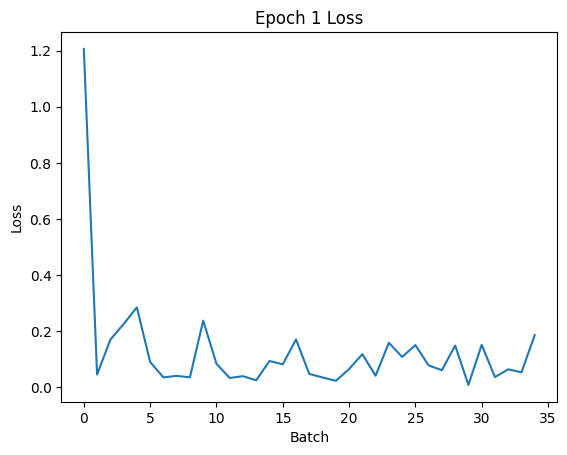

In [ ]:
# --- Training Loop ---
global_step = 0
num_epochs=10
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    # --- Data Loading and Deletion ---
    dataset = DiffusionImageDataset(output_folder, img_size, max_diffusion_timestep)

    # Optional: Delete older files before starting the epoch's training
    files_to_delete = dataset.get_files_to_delete(keep_fraction=0.8) # Keep 80% newest files
    files_to_delete=None
    if files_to_delete:
        print(f"Deleting {len(files_to_delete)} older files...")
        deleted_count = 0
        for f_path in files_to_delete:
            try:
                os.remove(f_path)
                deleted_count += 1
            except OSError as e:
                print(f"Error deleting file {f_path}: {e}")
        print(f"Deleted {deleted_count} files.")
        # Refresh file list after deletion
        dataset.refresh_files()

    if len(dataset) == 0:
        print("No images found to train on. Waiting for files...")
        time.sleep(60) # Wait a minute before trying again
        continue

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    model.train()
   
    steps_in_epoch = 0
    losses = []

    for batch_idx, (clean_images, timestep) in enumerate(dataloader): # We don't use the timestep from filename directly here
       

        clean_images = clean_images.to(device)

        # 1. Sample noise
        noise = torch.randn_like(clean_images)

        # 2. Sample timesteps
        # Ensure batch size matches the number of images
        current_batch_size = clean_images.shape[0]
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (current_batch_size,), device=device).long()

        # 3. Add noise to the clean images
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # 4. Predict the noise residual
        noise_pred = model(noisy_images, timesteps).sample # Access the sample attribute

        # 5. Calculate the loss
        loss = criterion(noise_pred, noise) # Compare predicted noise with actual noise

        # 6. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        global_step += 1
        steps_in_epoch += 1
        
        if batch_idx % 100 == 0:
            losses.append(loss.item())
            clear_output(wait=False)
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")
            plt.plot(losses)
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.title(f'Epoch {epoch+1} Loss')
            plt.show()

  

    # --- Save Model Checkpoint ---
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1: # Save every 5 epochs and at the end
        save_path = model_save_path.replace('.pth', f'_epoch{epoch+1}.pth')
        torch.save(model.state_dict(), save_path)
        print(f"Model checkpoint saved to {save_path}")

print("\nTraining finished.")
# Final model save
torch.save(model.state_dict(), model_save_path)
print(f"Final model saved to {model_save_path}")
          

In [ ]:
clean_images

tensor([[[[ 0.9922,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  0.9373,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 0.0980,  0.1451,  0.0353,  ..., -0.0667, -0.1373,  0.1529],
          [-0.1294, -0.2627, -0.1529,  ...,  0.3333, -0.0275, -0.0039],
          [-0.2000,  0.0118,  0.0745,  ..., -0.0196, -0.1137, -0.1922],
          ...,
          [-0.1294, -0.0118,  0.0588,  ...,  0.1294,  0.0588,  0.1294],
          [-0.0039, -0.0824,  0.3255,  ...,  0.0039,  0.2549,  0.1843],
          [ 0.0118,  0.2549,  0.0118,  ...,  0.1216,  0.0275, -0.2314]],

         [[-0.0745, -0.0118,  0.1608,  ...,  0.0510, -0.2314,  0.1922],
          [-0.1765, -0.0118,  